<img src="resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Workshop SWDB 2024 </h1> 
<h3 align="center">Day 1 2024 - Anatomy Introduction</h3> 
<h3 align="center">Notebook 0: Load and View neuron skeletons</h3> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
   
<p>Analyzing neuron morphology data begins with accessing it--and understanding how the data is structured. This notebook provides an example of how to load, examine, and visualize a neuron skeleton in both 2D and 3D. We introduce these tools by exploring two different datasets containing neurons that were imaged with <b>Electron Microscopy (EM) </b>and <b>Lightsheet Microscopy (LM).</b>
</div>

In [1]:
import pandas as pd
import numpy as np
from os.path import join as pjoin

import k3d
import matplotlib.pyplot as plt
%matplotlib inline

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
This cell sets up a variable called `data_root` that you should use in any code below to access the dataset in question (e.g. paths to manifest files for the SDK should be made relative to this variable).
</div>

In [2]:
import platform
platstring = platform.platform()

if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2024/anatomy/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/anatomy/"
elif ('amzn2' in platstring):
    # then on AWS
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2024/anatomy/"

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
 
<h2> Load the Skeleton Data from the precomputed format </h2>
    
<p> Neuroglancer is a web-based application for visualizing large-scale biological images and neuron morphology datasets. This tool requires that the data is stored as a "Precomputed" file, which is a format designed for large volumetric images, meshes, and skeletons. Our neuron data is stored in this precomputed skeleton format and we will use a python library called CloudVolume to load the neurons from both the Electron Microscopy (EM) and Lightsheet Microscopy (LM) datasets.
    
<p> <b> Any of the skeletons you selected in the neuroglancer demo, you can download and visualize here </b>
    
<p> <font size=4> <a href=https://spelunker.cave-explorer.org/#!middleauth+https://global.daf-apis.com/nglstate/api/v1/6703999991414784>Neuroglancer Demo in CCF </a> </font> </b>
    
<p> Below we import the package <a href="https://github.com/seung-lab/cloud-volume">CloudVolume</a>, which is a serverless Python client for random access reading and writing of Neuroglancer volumes in <a href="https://github.com/google/neuroglancer/blob/master/src/datasource/precomputed/skeletons.md">"Precomputed"</a> format, a set of representations for arbitrarily large volumetric images, meshes, and skeletons. 

<p> We will use cloudvolume to load precomputed skeletons from first the Electron Microscopy (EM) data and second Lightsheet Microscopy (LM) data.
    
<p> Note: For this course we have pre-loaded the data into the capsule or the hard drive. However, the data is the same you see in neuroglancer and can be accessed with the same cloud path. For example: <code>input_directory = "precomputed://gs://allen_neuroglancer_ccf/em_minnie65_v1078"</code>
    
</div>

In [3]:
import cloudvolume

In [4]:
#EM Data
input_directory = f"file://{data_root}/ccf_em_minnie65_v1078"
skeleton_id = 864691135591041291
cv_obj = cloudvolume.CloudVolume(input_directory) # Initialize cloud volume
cv_sk = cv_obj.skeleton.get(skeleton_id) #load an example skeleton

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p> A precomputed skeleton is a simplified representation of a neuron where its shape is captured by a tree-like structure that passes through the center of the neuron. More specificy, a precomputed skeleton stores a neuron as a graph with vertices and edges in addition to a collection of vertex-attached attributes that capture morphological and anatomical information about the neuron.

</div>

In [5]:
print("This is a precomputed skeleton of an EM neuron...\n")
print(cv_sk)

This is a precomputed skeleton of an EM neuron...

Skeleton(segid=864691135591041291, vertices=(shape=9154, float32), edges=(shape=9153, uint32), radius=(9154, float32), compartment=(9154, float32), presyn_counts=(9154, float32), postsyn_counts=(9154, float32), presyn_size=(9154, float32), postsyn_size=(9154, float32), space='physical' transform=[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0]])


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


<p> Each vertex of the skeleton is an [x,y,z] coordinate. The vertices and their edges form a 'geometric graph' that we will operate on in later notebooks
    
<p> Note: Observe that many attributes such as "radius" and "compartment" have the same shape as "vertices". Each vertex may also be associated with one or more other properties, including:
<ul>
    <li> <code>radius</code>: the estimated cross-section radius of the segment
    <li> <code>compartment</code>: whether the segment belongs to the axon, dendrite, or soma. 
</ul>

<p>We will see these properties rendered later in this notebook, and discuss the other properties synapse properties in later notebooks. 

</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> Convert precomputed skeleton to a meshwork skeleton </h2>
    
<p><a href="https://github.com/CAVEconnectome/MeshParty/">MeshPary</a> is a package that simplifies the analysis of morphological properties of neurons. A <code>meshwork</code> object can include the 3D meshes of a reconstructed neuron, the skeleton structure of that neuron, and related annotations such as synapse properties and myelination.

<p>We will use MeshParty's <code>skeleton</code> object to help plot and analyze the precomputed skeletons.

    
</div>

In [6]:
from meshparty import skeleton

In [7]:
sk = skeleton.Skeleton(cv_sk.vertices, 
                       cv_sk.edges, 
                       vertex_properties={'radius': cv_sk.radius,
                                          'compartment': cv_sk.compartment},  
                       root = len(cv_sk.edges), 
                       remove_zero_length_edges = False)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h2> Plot Skeleton in 2D </h2>
    
<p> <a href="https://github.com/AllenInstitute/skeleton_plot">Skeleton-plot</a> provides some handy utilities for plotting meshwork skeletons, including:
<ul>
<li> specifying the 2D orientation
<li> annotating somas
<li> labeling compartments by color
    
</div>

In [8]:
import skeleton_plot as skelplot

(7726840.5, 8438740.0, 1497648.0, 675351.375)

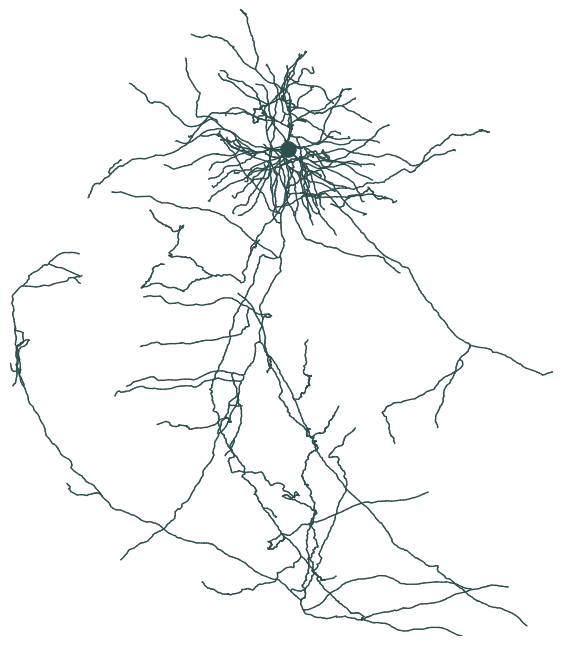

In [9]:
f, ax = plt.subplots(figsize=(7, 10))
skelplot.plot_tools.plot_skel(
    sk,
    line_width = 1,
    plot_soma = True,
    invert_y = True,
    x="x",
    y="y",
)

ax.spines['right'].set_visible(False) 
ax.spines['left'].set_visible(False) 
ax.spines['top'].set_visible(False) 
ax.spines['bottom'].set_visible(False)
ax.axis('off')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Here we have the example neuron rendered in 2D. You can change the plot properties such as: line width, axis orientation, and axes appearance. 
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1.1:</b>  Try changing the project from x-y to y-z to see how that changes your perception of the 3D structure
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h2> Add radius and compartment labels </h2>
    
<p> To get a more accurate understanding of the neuron's morphology, you can pull in information about the radius and compartment labels into your visualization. 
    
<p>Here the axon is colored black, basal dendrites 'firebrick' red, apical dendrites 'salmon' orange, and the soma a green 'olive'.
    
<p> <b>Compartment label conventions</b> (from standardized swc files <a href="www.neuromorpho.org">www.neuromorpho.org</a> )
<ul>
<li> 0 - undefined
<li> 1 - soma
<li> 2 - axon
<li> 3 - (basal) dendrite
<li> 4 - apical dendrite
<li> 5+ - custom
</ul>
    
</div>

(7726840.5, 8438740.0, 1497648.0, 675351.375)

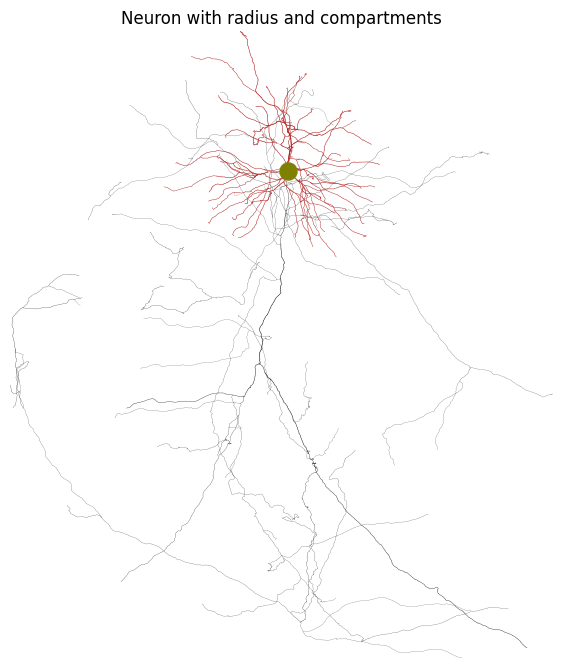

In [10]:
f, ax = plt.subplots(figsize=(7, 10))
skelplot.plot_tools.plot_skel(
    sk,
    title="Neuron with radius and compartments",
    line_width=1,
    plot_soma=True,
    soma_size = 150,
    pull_radius=True,
    invert_y=True,
    pull_compartment_colors=True,
    x="x",
    y="y",
    skel_color_map = { 1: "olive", 2: "black", 3: "firebrick",4: "salmon", },
    ax=ax,
)

ax.spines['right'].set_visible(False) 
ax.spines['left'].set_visible(False) 
ax.spines['top'].set_visible(False) 
ax.spines['bottom'].set_visible(False)
ax.axis('off')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1.2:</b>  Change the <code>skel_color_map</code> colors to suit your visual preference. 

<p> To see more plotting features, enter <code>skelplot.plot_tools.plot_skel?</code> to see the function documentation
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h3> Plot skeleton in 3D (with k3d) </h3>

<p> Of course, neurons are three-dimensional structures, and so we also want to inspect their morphology in 3D. For this, we will use the interactive 3D rendering package, k3d.
    
</div>

In [11]:
import random

# Define plotting functions to turn a skeleton into line objects
def plot_graphs(graphs, plot, color = None):
    
    for i, g in enumerate(graphs):
        if color == None:
            colorstr = "%06x" % random.randint(0, 0xFFFFFF)
            c  = int(colorstr, 16) + 0x200
        elif type(color) == type([]):
            c = color[i]
        else:
            c = color
        g_lines = graph_to_lines(g,c)
        plot += g_lines
        

def graph_to_lines(g,color=None):
    # Extract vertex positions
    g_verts = g.vertices
    
    # Pairs of indices into the vertex array are edges
    g_inds = g.edges
    
    # Could add iteration here to plot compartments in different colors
    
    g_lines = k3d.factory.lines(g_verts, g_inds, indices_type='segment', width=1, shader='simple',color=color)
    return g_lines

In [12]:
plot = k3d.plot()
plot_graphs([sk], plot)
plot.display()

/opt/conda/lib/python3.9/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "int64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


Output()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h2> Exercises </h2>
    
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><h3>Load an Light Microscopy (LM) cell</h3>
</div>

In [13]:
#Example Cell to Load:
input_directory = f"file://{data_root}/exaSPIM_609281_2022-11-03_13-49-18_reconstructions/precomputed/"

skeleton_id = 1
cv_obj = cloudvolume.CloudVolume(input_directory) # Initialize cloud volume
cv_sk = cv_obj.skeleton.get(skeleton_id) #load an example skeleton


sk = skeleton.Skeleton(cv_sk.vertices, 
                       cv_sk.edges, 
                       vertex_properties={'radius': cv_sk.radius,
                                          'compartment': cv_sk.compartment}, 
                       root = 0, 
                       remove_zero_length_edges = False)


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.1:</b>  Look at the vertex_properties of the skeleton object. How many unique compartment types are there?
    
<p> What vertex-level attributes does the EM neuron have that the LM neuron lacks? Why do you think these attributes are absent in the LM neuron. (Hint: it is related to the resolution of the microscope).

<p>(Note that the LM neurons do not have radii associated with vertices and are set to 1)
</div>

In [14]:
#Answer

print(sk.vertex_properties)
print(np.unique(sk.vertex_properties['compartment']))

{'radius': array([1., 1., 1., ..., 1., 1., 1.], dtype=float32), 'compartment': array([1., 3., 3., ..., 2., 2., 2.], dtype=float32)}
[1. 2. 3.]


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.2:</b>  View it in 2D
</div>

(3795229.0, 14178638.0, 7191575.0, 2148295.0)

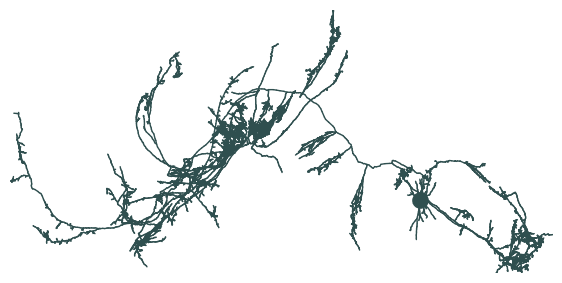

In [15]:
#Answer

f, ax = plt.subplots(figsize=(7, 10))
skelplot.plot_tools.plot_skel(
    sk,
    line_width = 1,
    plot_soma = True,
    invert_y = True,
    x="x",
    y="y",
)

ax.spines['right'].set_visible(False) 
ax.spines['left'].set_visible(False) 
ax.spines['top'].set_visible(False) 
ax.spines['bottom'].set_visible(False)
ax.axis('off')



<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.3:</b>  View it in 3D
</div>

In [16]:
#Answer
plot = k3d.plot()
plot_graphs([sk], plot)
plot.display()

Output()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.4:</b>  View it with colored compartments
</div>

(3795229.0, 14178638.0, 7191575.0, 2148295.0)

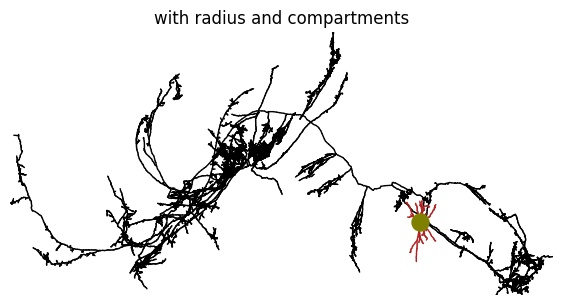

In [17]:
#Answer
f, ax = plt.subplots(figsize=(7, 10))
skelplot.plot_tools.plot_skel(
    sk,
    title="with radius and compartments",
    line_width=1,
    plot_soma=True,
    soma_size = 150,
    pull_radius=True,
    invert_y=True,
    pull_compartment_colors=True,
    x="x",
    y="y",
    skel_color_map = { 3: "firebrick",4: "salmon",2: "black",1: "olive" },
)

ax.spines['right'].set_visible(False) 
ax.spines['left'].set_visible(False) 
ax.spines['top'].set_visible(False) 
ax.spines['bottom'].set_visible(False)
ax.axis('off')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.5:</b>  Visualize Mesh of CCF atlas
</div>

In [18]:

import trimesh
import k3d

plot = k3d.plot()


with open(f"{data_root}/AllenCCFMesh/MouseBrainAllen3.obj") as f:
    ccf_mesh = trimesh.load(f, 'obj')


mesh = k3d.mesh(ccf_mesh.vertices*1000, ccf_mesh.faces, opacity = 0.2, color=808080) #note that units are not in microns
plot += mesh
plot.display()

/opt/conda/lib/python3.9/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "int64" does not match required type "uint32". A coerced copy has been created.
  warnings.warn(


Output()